<h1> Project. Deep Learning

<h3>RNN Model (1st Model)




In [1]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np

In [305]:
# dataset parameters.
num_classes = 2 # total classes (2).
num_features = 10000 # data features (100*100).
# Training Parameters
learning_rate = 0.001
training_steps = 200
batch_size = 128
display_step = 100
# Network Parameters
# Dataset image shape is 1000*1000, we will then handle 1000 sequences of 1000 timesteps for every sample.
num_input = 100 # number of sequences.
timesteps = 100 # timesteps.
num_units = 128 # number of neurons for the LSTM layer.

In [3]:
from keras import backend as K
from keras import activations
from keras import utils
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras import regularizers
import pandas as pd
import matplotlib.pyplot as plt
import os

In [4]:
def DataGenerator(train_batch, val_batch, IMG_SIZE):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale=1./255,
                                 rotation_range=10,
                                 horizontal_flip=True,
                                 vertical_flip=True)

    datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
    train_gen = datagen.flow_from_directory('C:/Users/mdavo/Desktop/archive/chest_xray/train/',
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            color_mode='rgb', 
                                            class_mode='categorical',
                                            batch_size=train_batch)
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
    val_gen = datagen.flow_from_directory('C:/Users/mdavo/Desktop/archive/chest_xray/val/', 
                                          target_size=(IMG_SIZE, IMG_SIZE),
                                          color_mode='rgb', 
                                          class_mode='categorical',
                                          batch_size=val_batch)
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale=1./255)
    
    datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)

    test_gen = datagen.flow_from_directory('C:/Users/mdavo/Desktop/archive/chest_xray/test/',
                                           target_size=(IMG_SIZE, IMG_SIZE),
                                           color_mode='rgb', 
                                           class_mode='categorical',
                                           shuffle=False)
    
    return train_gen, val_gen, test_gen

In [6]:
train_batch = 32
val_batch = 1
IMG_SIZE = 100
train, val, test = DataGenerator(train_batch, val_batch, IMG_SIZE)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
x_test=np.concatenate([test.next()[0] for i in range(test.__len__())])

In [8]:
y_test=np.concatenate([test.next()[1] for i in range(test.__len__())])

In [9]:
y_train=np.concatenate([train.next()[1] for i in range(train.__len__())])

In [11]:
x_train2=np.concatenate([train.next()[0] for i in range(train.__len__())])

In [12]:
x_train = x_train2[:, :, :, 0]

In [14]:
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Flatten images to 1-D vector of 10000 features (100*100).
x_train, x_test = x_train.reshape([-1, 100, 100]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [15]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [16]:
# Create Bidirectinal RNN LSTM Model.
class BiRNN(Model):
    # Set layers.
    def __init__(self):
        super(BiRNN, self).__init__()
        # Define 2 LSTM layers for forward and backward sequences.
        lstm_fw = layers.LSTM(units=num_units, return_sequences=True)
        lstm_bw = layers.LSTM(units=num_units, go_backwards=True)
        # BiRNN layer.
        self.bi_lstm = layers.Bidirectional(lstm_fw, backward_layer=lstm_bw)
        # Output layer (num_classes).
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = self.bi_lstm(x)
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x
    
# Build LSTM model.
birnn_net = BiRNN()

In [17]:
# Cross-Entropy Loss.
# Note that this will apply 'softmax' to the logits.
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

In [323]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [325]:
import torch

In [393]:
# Adam optimizer.
optimizer = tf.optimizers.Adam(learning_rate)

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of the highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass
        pred = birnn_net(x, is_training=True)
        #print(pred)
        # Compute loss
        loss = cross_entropy_loss(pred, y)

    # Variables to update, i.e. trainable variables.
    trainable_variables = birnn_net.trainable_variables

    # Compute gradients
    gradients = g.gradient(loss, trainable_variables)
    
    # Update weights following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))
# Train model.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    batch_x = tf.reshape(batch_x, [-1, timesteps, num_input])

    # Run optimization op (backpropagation).
    run_optimization(batch_x, batch_y)

    if step / display_step == 1 or step / display_step == 2 or step ==100 or step == 200:
        if step / display_step == 2:
            pred2=pred
        if step==100:
            pred3=pred
        # Calculate batch loss and accuracy.
        pred = birnn_net(batch_x, is_training=True)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))



step: 100, loss: 0.543462, accuracy: 0.773438
step: 200, loss: 0.586760, accuracy: 0.734375
step: 300, loss: 0.524652, accuracy: 0.789062


In [26]:
from tensorflow.keras.models import load_model
birnn_net.save('C:/Users/mdavo/Desktop/Model')

INFO:tensorflow:Assets written to: C:/Users/mdavo/Desktop/Model\assets


INFO:tensorflow:Assets written to: C:/Users/mdavo/Desktop/Model\assets


In [45]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
img_path = 'C:/Users/mdavo/Desktop/archive/chest_xray/train/PNEUMONIA_resized/PNEUMONIAperson1_bacteria_1_resized.jpg'
img = image.load_img(img_path, target_size=(100, 100))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img = img_array[:, :, :, 0]
pred = birnn_net(img, is_training=True)
if pred[0][0] > 0.5:print('Pneumonia')
else:print('Normal')
print(pred[0][0])

Normal


<h3>CNN Model (2nd Model)

In [48]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [49]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os
from glob import glob
import cv2

from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
#from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

import warnings
# filter warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [50]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for jax: filename=jax-0.4.10-py3-none-any.whl size=1480617 sha256=05ffdc12ea06490c6ff184f5128a419a1ddc3fe119b963150aa54d25e865d004
  Stored in directory: c:\users\mdavo\appdata\local\pip\cache\wheels\e5\6c\70\7c6be85fa56f05480fe043bdf0d4f6ec316b122be21e098066
Successfully built jax
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.6.2
    Uninstalling google-auth-2.6.2:
      Successfully uninstalled google-auth-2.6.2
  Attempting uninstall: tensorboard-data-server
    Found existing

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'E:\\Programs\\Anaconda\\Lib\\site-packages\\google\\~rotobuf\\internal\\_api_implementation.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires keras<2.9,>=2.8.0rc0, but you have keras 2.12.0 which is incompatible.


In [155]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')


In [454]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [455]:
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
main_path = "E:/Dars/DL/Project/archive/chest_xray/chest_xray"
#main_path = "/content/chest_xray"

train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [456]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

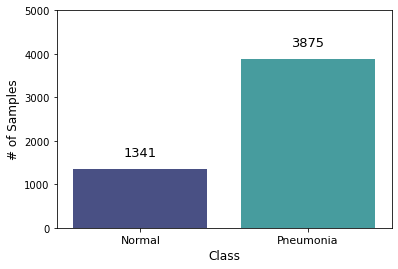

In [159]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

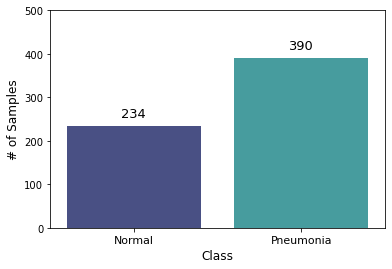

In [239]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_test, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,500)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+20), fontsize = 13)
    
plt.show()

Train Set - Normal


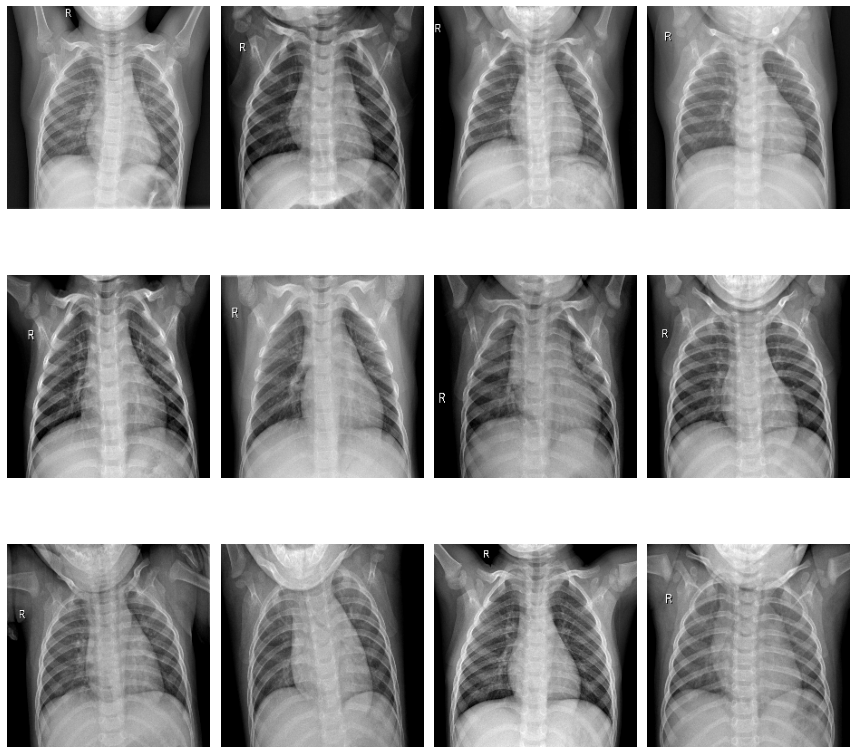

In [163]:
print('Train Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Train Set - Pneumonia


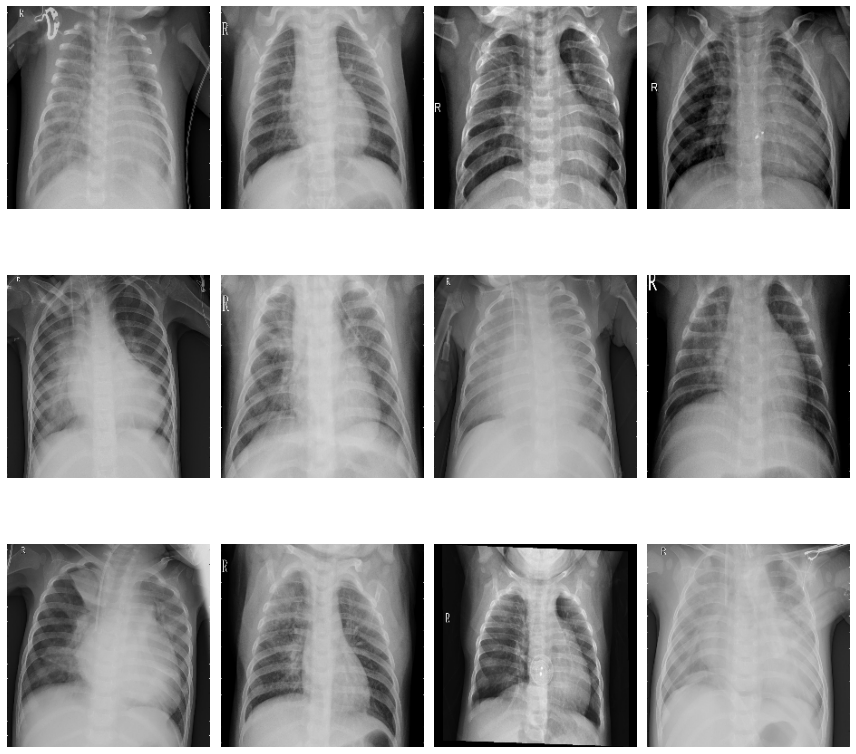

In [164]:
print('Train Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Normal


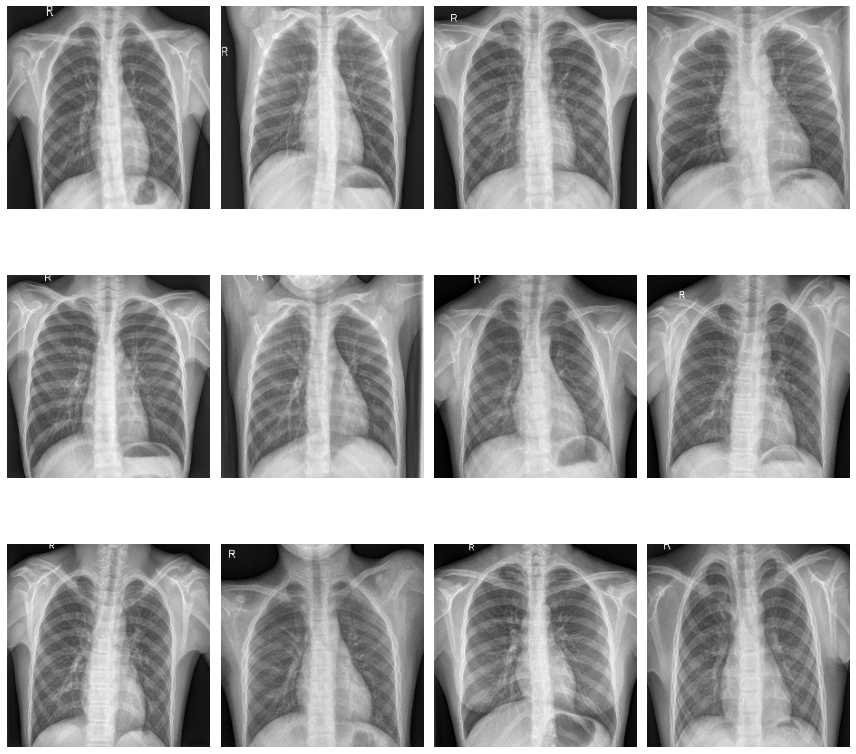

In [165]:

print('Test Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Pneumonia


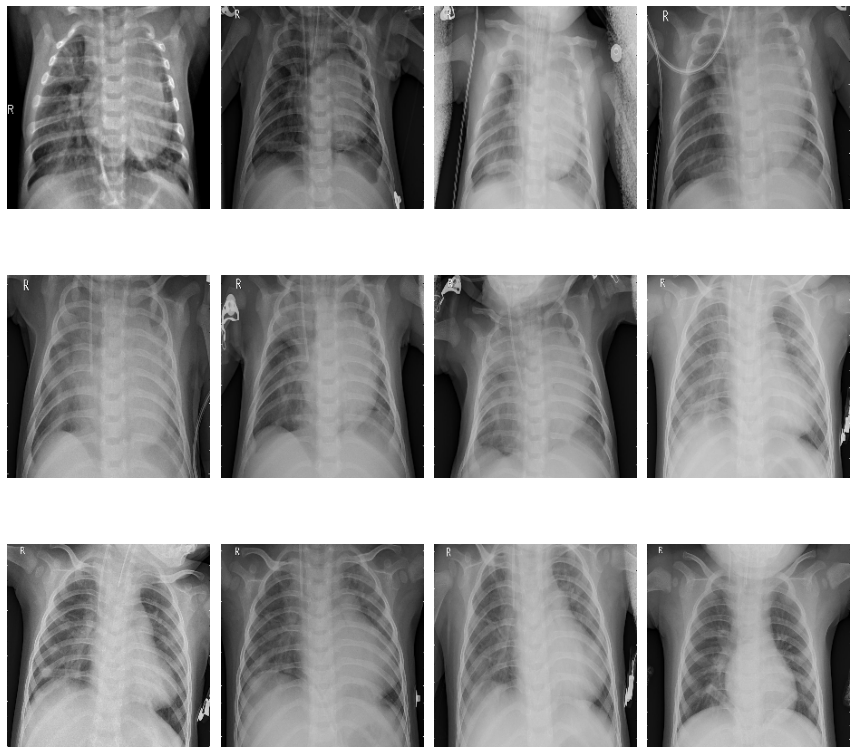

In [166]:
print('Test Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

In [457]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [458]:
train_df

,class,image
99,Normal,E:/Dars/DL/Project/archive/chest_xray/chest_xray\train/NORMAL\IM-0273-0001.jpeg
1284,Normal,E:/Dars/DL/Project/archive/chest_xray/chest_xray\train/NORMAL\NORMAL2-IM-1306-0001.jpeg
5142,Pneumonia,E:/Dars/DL/Project/archive/chest_xray/chest_xray\train/PNEUMONIA\person963_virus_1636.jpeg
1365,Pneumonia,E:/Dars/DL/Project/archive/chest_xray/chest_xray\train/PNEUMONIA\person1016_bacteria_2947.jpeg
2649,Pneumonia,E:/Dars/DL/Project/archive/chest_xray/chest_xray\train/PNEUMONIA\person1604_virus_2782.jpeg
...,...,...
4481,Pneumonia,E:/Dars/DL/Project/archive/chest_xray/chest_xray\train/PNEUMONIA\person611_bacteria_2476.jpeg
2404,Pneumonia,E:/Dars/DL/Project/archive/chest_xray/chest_xray\train/PNEUMONIA\person1491_bacteria_3893.jpeg
705,Normal,E:/Dars/DL/Project/archive/chest_xray/chest_xray\train/NORMAL\NORMAL2-IM-0523-0001.jpeg
3732,Pneumonia,E:/Dars/DL/Project/archive/chest_xray/chest_xray\train/PNEUMONIA\person420_bacteria_1847.jpeg


In [459]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [460]:
#Setting callbakcs

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

In [461]:
def get_model():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [462]:
keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

In [463]:
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 3,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
131/130 [==============================] - ETA: 0s - loss: 0.5419 - binary_accuracy: 0.7447WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001B16D3F6670> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
130/130 [==============================] - 124s 951ms/step - loss: 0.5419 - binary_accuracy: 0.7447 - val_loss: 0.8804 - val_binary_accuracy: 0.7433 - lr: 3.0000e-05
Epoch 2/3
130/130 [==============================] - 125s 957ms/step - loss: 0.3394 - binary_accuracy: 0.8523 - val_loss: 1.4552 - val_binary_accuracy: 0.7433 - lr: 3.0000e-05
Epoch 3/3
131/130 [==============================] - ETA: 0s - loss: 0.2732 - binary_accuracy: 0.8814
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
130/130 [==============================] - 130s 995ms/step - loss: 0.2732 - binary_accuracy: 0.8814 - val_loss: 1.7467 - val_binary_accu

In [465]:

#Checking for a single image
from keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing import image
# Load the image to be classified
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
img_path = 'E:/Dars/DL/Project/archive/chest_xray/chest_xray/train/PNEUMONIA/person20_bacteria_64.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Load the model
model = model # your trained model, use the code snippets from earlier to load the model

# Make a prediction
prediction = model.predict(img_array)

# Print the predicted class
if prediction.shape == (1, 1):
    if prediction[0][0] > 0.5:
        print('Pneumonia')
    else:
        print('Normal')
elif prediction.shape == (1, 2):
    if prediction[0][0] > prediction[0][1]:
        print('Normal')
    else:
        print('Pneumonia')
else:
    print('Unexpected prediction shape:', prediction.shape)


Pneumonia


In [92]:
pip install keras.optimizers

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement keras.optimizers (from versions: none)
ERROR: No matching distribution found for keras.optimizers


<h3>VGG16 Model (3rd Model)

In [259]:

# load dependencies
from __future__ import print_function
import tensorflow as tf   # Using tensorflow 2.0.0
from keras import layers, initializers
from keras import backend as K
from keras import activations
from keras import utils
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
#from tensorflow.keras.optimizers import Adam 
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam
#from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import regularizers


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

IMG_SIZE = 299

In [260]:
# This code block should create an instance of an ImageDataGenerator called datagen 
def DataGenerator(train_batch, val_batch, IMG_SIZE):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale=1./255,#rescale factor
                                 rotation_range=10,# Degree range for random rotations.
                                 horizontal_flip=True,#horizontal flip in images
                                 vertical_flip=True)#vertical flip in images

    datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
    train_gen = datagen.flow_from_directory('E:/Dars/DL/Project/archive/chest_xray/chest_xray/train/',
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            color_mode='rgb', 
                                            class_mode='categorical',
                                            batch_size=train_batch)
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
    val_gen = datagen.flow_from_directory('E:/Dars/DL/Project/archive/chest_xray/chest_xray/val/', 
                                          target_size=(IMG_SIZE, IMG_SIZE),
                                          color_mode='rgb', 
                                          class_mode='categorical',
                                          batch_size=val_batch)

    datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale=1./255)
    
    datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
    test_gen = datagen.flow_from_directory('E:/Dars/DL/Project/archive/chest_xray/chest_xray/test/', 
                                           target_size=(IMG_SIZE, IMG_SIZE),
                                           color_mode='rgb', 
                                           class_mode='categorical',
                                           shuffle=False)
    
    return train_gen, val_gen, test_gen

In [261]:
#Generating data for training using Image Generator defined above
train_batch = 32
val_batch = 1

train, val, test = DataGenerator(train_batch, val_batch, IMG_SIZE)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [262]:

input_image = Input(shape=(IMG_SIZE, IMG_SIZE, 3))


# A InceptionResNetV2 Conv2D model
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_image)

base_model.summary()
     

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0     

In [264]:

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

model2 = Model(inputs=input_image, outputs=output)

model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0   

In [265]:
from keras import optimizers


In [266]:

from tensorflow.keras import optimizers

lr=1e-4
#from keras.optimizers import RMSprop
#model.compile(loss='categorical_crossentropy', optimizer= optimizers.RMSprop(lr=lr), metrics=['accuracy'])
model2.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=lr), metrics=['accuracy'])

#model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=lr), metrics=['accuracy'])


In [268]:

model2.fit_generator(train,
                    epochs=3,
                    validation_data=val, 
                    validation_steps = len(val.classes)//val_batch,
                    steps_per_epoch=(len(train.classes)//train_batch) ) 
    
loss, acc = model2.evaluate_generator(test, len(test))

print ("\n\n================================\n\n")
print ("Loss: {}".format(loss))
print ("Accuracy: {0:.2f} %".format(acc * 100))
print ("\n\n================================\n\n")

test.reset()

Epoch 1/3
163/163 [==============================] - ETA: 0s - loss: 0.4032 - accuracy: 0.8190 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001B159798DC0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
163/163 [==============================] - 2205s 14s/step - loss: 0.4032 - accuracy: 0.8190 - val_loss: 1.6523 - val_accuracy: 0.6250
Epoch 2/3
163/163 [==============================] - 2190s 13s/step - loss: 0.2481 - accuracy: 0.9070 - val_loss: 0.4877 - val_accuracy: 0.6875
Epoch 3/3
163/163 [==============================] - 2186s 13s/step - loss: 0.2055 - accuracy: 0.9206 - val_loss: 0.4992 - val_accuracy: 0.6875




Loss: 0.2804323732852936
Accuracy: 88.30 %






<h3>Testing the outputs

In [422]:
from keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing import image
# Load the image to be classified
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
img_path = 'E:/Dars/DL/Project/archive/chest_xray/chest_xray/train/PNEUMONIA/person1007_virus_1690.jpeg'
img = image.load_img(img_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Load the model
model2 = model2 # your trained model, use the code snippets from earlier to load the model

# Make a prediction
prediction = model2.predict(img_array)

# Print the predicted class
if prediction.shape == (1, 1):
    if prediction[0][0] > 0.5:
        print('Pneumonia')
    else:
        print('Normal')
elif prediction.shape == (1, 2):
    if prediction[0][0] > prediction[0][1]:
        print('Normal')
    else:
        print('Pneumonia')
else:
    print('Unexpected prediction shape:', prediction.shape)


Pneumonia


In [471]:
results1 = []


#Number of images we want to use
no_of_images = 1000
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
folder_dir = "E:/Dars/DL/Project/archive/chest_xray/chest_xray/train/NORMAL/"
normal_img_count = 0
for images in os.listdir(folder_dir):
#  img_path = '/content/gdrive/MyDrive/kaggle_dataset/chest_xray/train/NORMAL/IM-0115-0001.jpeg'
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
  img_path = "E:/Dars/DL/Project/archive/chest_xray/chest_xray/train/NORMAL/" + images
  img = image.load_img(img_path, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  # Load the model
  model = model # your trained model, use the code snippets from earlier to load the model

  # Make a prediction
  prediction = model.predict(img_array)

  # Print the predicted class
  if prediction.shape == (1, 1):
      if prediction[0][0] > 0.5:
          results1.append(1)
      else:
          results1.append(0)
  elif prediction.shape == (1, 2):
      if prediction[0][0] > prediction[0][1]:
          results1.append(0)
      else:
          results1.append(1)
  else:
      print('Unexpected prediction shape:', prediction.shape)

  normal_img_count = normal_img_count + 1
 # print(img_path)
  if(normal_img_count== no_of_images):
    break







################################################################################################################





results2 = []
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
folder_dir = "E:/Dars/DL/Project/archive/chest_xray/chest_xray/train/NORMAL/"
normal_img_count = 0
for images in os.listdir(folder_dir):
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.    
  img_path = "E:/Dars/DL/Project/archive/chest_xray/chest_xray/train/NORMAL/" + images
  img = image.load_img(img_path, target_size=(299, 299))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  # Load the model
  model2 = model2 # your trained model, use the code snippets from earlier to load the model

  # Make a prediction
  prediction = model2.predict(img_array)

  # Print the predicted class
  if prediction.shape == (1, 1):
      if prediction[0][0] > 0.5:
          results2.append(1)
      else:
          results2.append(0)
  elif prediction.shape == (1, 2):
      if prediction[0][0] > prediction[0][1]:
          results2.append(0)
      else:
          results2.append(1)
  else:
      print('Unexpected prediction shape:', prediction.shape)

  normal_img_count = normal_img_count + 1
 # print(img_path)
  if(normal_img_count== no_of_images):
    break



################################################################################################################



results3 = []
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
folder_dir = "E:/Dars/DL/Project/archive/chest_xray/chest_xray/train/NORMAL/"
normal_img_count = 0
for images in os.listdir(folder_dir):
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
  img_path = "E:/Dars/DL/Project/archive/chest_xray/chest_xray/train/NORMAL/" + images
  img = image.load_img(img_path, target_size=(100, 100))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  # Load the model
#  birnn_net = birnn_net # your trained model, use the code snippets from earlier to load the model

  # Make a prediction
  img = img_array[:, :, :, 0]
  predtest2 = birnn_net(img, is_training=True)
#  prediction = model.predict(img_array)

  # Print the predicted class
  if predtest2[0][0] > -5:
    results3.append(1)
  else:
    results3.append(0)
#  else:
#    print('Unexpected prediction shape:', prediction.shape)
  normal_img_count = normal_img_count + 1
 # print(img_path)
  if(normal_img_count== no_of_images):
    break

In [424]:
len(results3)

1000

<h3>Combining the Models

In [472]:
#For Normal Images

ans = [0,0,0]
wt = [0,0,0]

for i in range(no_of_images):
  wrong_ans = 0
  if(results1[i] == 0):
    #It means model predicted right output
    ans[0] = 1
  else:
    ans[0] = 0
    wrong_ans += 1
  if(results2[i] == 0):
    ans[1] = 1
  else:
    ans[1] = 0
    wrong_ans += 1
  if(results3[i] == 0):
    ans[2] = 1
  else:
    ans[2] = 0
    wrong_ans += 1
  
  #Weighted approach 
  if(ans[0] == 1):
    wt[0] = wt[0] + (wrong_ans/3)

  if(ans[1] == 1):
    wt[1] = wt[1] + (wrong_ans/3)

  if(ans[2] == 1):
    wt[2] = wt[2] + (wrong_ans/3)
  

In [473]:
wt

[4.333333333333333, 54.66666666666676, 52.33333333333342]

In [474]:
results1 = []


#Number of images we want to use
no_of_images = 1000
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
folder_dir = "E:/Dars/DL/Project/archive/chest_xray/chest_xray/train/PNEUMONIA/"
normal_img_count = 0
for images in os.listdir(folder_dir):
#  img_path = '/content/gdrive/MyDrive/kaggle_dataset/chest_xray/train/NORMAL/IM-0115-0001.jpeg'
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
  img_path = "E:/Dars/DL/Project/archive/chest_xray/chest_xray/train/PNEUMONIA/" + images
  img = image.load_img(img_path, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  # Load the model
  model = model # your trained model, use the code snippets from earlier to load the model

  # Make a prediction
  prediction = model.predict(img_array)

  # Print the predicted class
  if prediction.shape == (1, 1):
      if prediction[0][0] > 0.5:
          results1.append(1)
      else:
          results1.append(0)
  elif prediction.shape == (1, 2):
      if prediction[0][0] > prediction[0][1]:
          results1.append(0)
      else:
          results1.append(1)
  else:
      print('Unexpected prediction shape:', prediction.shape)

  normal_img_count = normal_img_count + 1
 # print(img_path)
  if(normal_img_count== no_of_images):
    break







################################################################################################################





results2 = []
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
folder_dir = "E:/Dars/DL/Project/archive/chest_xray/chest_xray/train/PNEUMONIA/"
normal_img_count = 0
for images in os.listdir(folder_dir):
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
  img_path = "E:/Dars/DL/Project/archive/chest_xray/chest_xray/train/PNEUMONIA/" + images
  img = image.load_img(img_path, target_size=(299, 299))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  # Load the model
  model2 = model2 # your trained model, use the code snippets from earlier to load the model

  # Make a prediction
  prediction = model2.predict(img_array)

  # Print the predicted class
  if prediction.shape == (1, 1):
      if prediction[0][0] > 0.5:
          results2.append(1)
      else:
          results2.append(0)
  elif prediction.shape == (1, 2):
      if prediction[0][0] > prediction[0][1]:
          results2.append(0)
      else:
          results2.append(1)
  else:
      print('Unexpected prediction shape:', prediction.shape)

  normal_img_count = normal_img_count + 1
 # print(img_path)
  if(normal_img_count== no_of_images):
    break



################################################################################################################



results3 = []
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
folder_dir = "E:/Dars/DL/Project/archive/chest_xray/chest_xray/train/PNEUMONIA/"
normal_img_count = 0
for images in os.listdir(folder_dir):
#  img_path = '/content/gdrive/MyDrive/kaggle_dataset/chest_xray/train/NORMAL/IM-0115-0001.jpeg'
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
  img_path = "E:/Dars/DL/Project/archive/chest_xray/chest_xray/train/PNEUMONIA/" + images
  img = image.load_img(img_path, target_size=(100, 100))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  # Load the model
  birnn_net = birnn_net # your trained model, use the code snippets from earlier to load the model

  # Make a prediction
  img = img_array[:, :, :, 0]
  pred = birnn_net(img, is_training=True)
#  prediction = model.predict(img_array)

  # Print the predicted class
  if pred[0][0] > 0.5:
    results3.append(1)
  else:
    results3.append(0)
#  else:
#    print('Unexpected prediction shape:', prediction.shape)
  normal_img_count = normal_img_count + 1
 # print(img_path)
  if(normal_img_count== no_of_images):
    break

In [475]:
#For Pneumonia images
ans = [0,0,0]
#wt = [0,0,0]

for i in range(no_of_images):
  wrong_ans = 0
  if(results1[i] == 1):
    # If the model predicted pneumonia answer is 1
    ans[0] = 1
  else:
    ans[0] = 0
    wrong_ans += 1
  if(results2[i] == 1):
    ans[1] = 1
  else:
    ans[1] = 0
    wrong_ans += 1
  if(results3[i] == 1):
    ans[2] = 1
  else:
    ans[2] = 0
    wrong_ans += 1
  
  if(ans[0] == 1):
    wt[0] = wt[0] + (wrong_ans/3)

  if(ans[1] == 1):
    wt[1] = wt[1] + (wrong_ans/3)

  if(ans[2] == 1):
    wt[2] = wt[2] + (wrong_ans/3)

<h3>The final weights of each model respectively (CNN, VGG16, RNN)

In [476]:
wt

[331.99999999999994, 325.66666666666725, 52.33333333333342]

<h3>Training the combination

In [501]:
no_of_images = 234

final_result2 = []

# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
folder_dir = "E:/Dars/DL/Project/archive/chest_xray/chest_xray/test/PNEUMONIA/"
#folder_dir2 = "C:/Users/mdavo/Desktop/archive/chest_xray/test/PNEUMONIA_resized/"

normal_img_count = 0
for images in os.listdir(folder_dir):
#  img_path = '/content/gdrive/MyDrive/kaggle_dataset/chest_xray/train/NORMAL/IM-0115-0001.jpeg'
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
  img_path = "E:/Dars/DL/Project/archive/chest_xray/chest_xray/test/PNEUMONIA/" + images
  img1 = image.load_img(img_path, target_size=(224, 224))
  img2 = image.load_img(img_path, target_size=(299, 299))
  img3 = image.load_img(img_path, target_size=(100, 100))
  img_array1 = image.img_to_array(img1)
  img_array2 = image.img_to_array(img2)
  img_array3 = image.img_to_array(img3)
    
    
  img_array1 = np.expand_dims(img_array1, axis=0)
  img_array2 = np.expand_dims(img_array2, axis=0)
  img_array3 = np.expand_dims(img_array3, axis=0)
  img = img_array3[:, :, :, 0]
  # Load the model
#  model = model # your trained model, use the code snippets from earlier to load the model

  # Make a prediction
  prediction1 = model.predict(img_array1)
  prediction2 = model2.predict(img_array2)
  prediction3 = birnn_net(img, is_training=True)

  zero_output = 0
  one_output = 0
  #Final prediction value here
  final_output = 0


  # Print the predicted class
  if prediction1.shape == (1, 1):
      if prediction1[0][0] > 0.5:
     #     results1.append(1)
          one_output = one_output + wt[0]
      else:
          p1 = 0
          zero_output = zero_output + wt[0]
          #results1.append(0)
  elif prediction1.shape == (1, 2):
      if prediction1[0][0] > prediction1[0][1]:
          #results1.append(0)
          zero_output = zero_output + wt[0]
      else:
         # results1.append(1)
          one_output = one_output + wt[0]
  else:
      print('Unexpected prediction shape:', prediction1.shape)




  if prediction2.shape == (1, 1):
      if prediction2[0][0] > 0.5:
          #results1.append(1)
          one_output = one_output + wt[1]
      else:
    #      results1.append(0)
          zero_output = zero_output + wt[1]
  elif prediction2.shape == (1, 2):
      if prediction2[0][0] > prediction2[0][1]:
         # results1.append(0)
          zero_output = zero_output + wt[1]
      else:
         # results1.append(1)
          one_output = one_output + wt[1]
  else:
      print('Unexpected prediction shape:', prediction2.shape)



  if prediction3[0][0] >-5:
    one_output = one_output + wt[2]
  else:
    zero_output = zero_output + wt[2]


  normal_img_count = normal_img_count + 1

  if(one_output > zero_output):
    final_output = 1
    final_result2.append(1)
  else:
    final_result2.append(0)
 # print(img_path)
  if(normal_img_count==no_of_images):
    break

In [503]:
no_of_images = 234


final_result = []

# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
folder_dir = "E:/Dars/DL/Project/archive/chest_xray/chest_xray/test/NORMAL/"
#folder_dir2 = "C:/Users/mdavo/Desktop/archive/chest_xray/test/NORMAL_resized/"

normal_img_count = 0
for images in os.listdir(folder_dir):
#  img_path = '/content/gdrive/MyDrive/kaggle_dataset/chest_xray/train/NORMAL/IM-0115-0001.jpeg'
# Attention TA: Please change the directory path according to your convenience wherever you will store the dataset.
# The directory path here is the path where we have store the dataset in our local machine.
  img_path = "E:/Dars/DL/Project/archive/chest_xray/chest_xray/test/NORMAL/" + images
  img1 = image.load_img(img_path, target_size=(224, 224))
  img2 = image.load_img(img_path, target_size=(299, 299))
  img3 = image.load_img(img_path, target_size=(100, 100))
  img_array1 = image.img_to_array(img1)
  img_array2 = image.img_to_array(img2)
  img_array3 = image.img_to_array(img3)
    
    
  img_array1 = np.expand_dims(img_array1, axis=0)
  img_array2 = np.expand_dims(img_array2, axis=0)
  img_array3 = np.expand_dims(img_array3, axis=0)
  img = img_array3[:, :, :, 0]
  # Load the model
#  model = model # your trained model, use the code snippets from earlier to load the model

  # Make a prediction
  prediction1 = model.predict(img_array1)
  prediction2 = model2.predict(img_array2)
  prediction3 = birnn_net(img, is_training=True)

  zero_output = 0
  one_output = 0
  #Final prediction value here
  final_output = 0


  # Print the predicted class
  if prediction1.shape == (1, 1):
      if prediction1[0][0] > 0.5:
     #     results1.append(1)
          one_output = one_output + wt[0]
      else:
          p1 = 0
          zero_output = zero_output + wt[0]
          #results1.append(0)
  elif prediction1.shape == (1, 2):
      if prediction1[0][0] > prediction1[0][1]:
          #results1.append(0)
          zero_output = zero_output + wt[0]
      else:
         # results1.append(1)
          one_output = one_output + wt[0]
  else:
      print('Unexpected prediction shape:', prediction1.shape)




  if prediction2.shape == (1, 1):
      if prediction2[0][0] > 0.5:
          #results1.append(1)
          one_output = one_output + wt[1]
      else:
    #      results1.append(0)
          zero_output = zero_output + wt[1]
  elif prediction2.shape == (1, 2):
      if prediction2[0][0] > prediction2[0][1]:
         # results1.append(0)
          zero_output = zero_output + wt[1]
      else:
         # results1.append(1)
          one_output = one_output + wt[1]
  else:
      print('Unexpected prediction shape:', prediction2.shape)



  if prediction3[0][0] > -5:
    one_output = one_output + wt[2]
  else:
    zero_output = zero_output + wt[2]


  normal_img_count = normal_img_count + 1

  if(one_output > zero_output):
    final_output = 1
    final_result.append(1)
  else:
    final_result.append(0)
 # print(img_path)
  if(normal_img_count==no_of_images):
    break

In [504]:
len(final_result)

234

<h3>Calculating the Final Accuracy

In [506]:
count_wrong_values = 0
#Firstly check for normal images
for i in range(234):
  if(final_result[i] == 1):
    count_wrong_values = count_wrong_values + 1

#Check for pneumonic images 
for i in range(234):
  if(final_result2[i] == 0):
    count_wrong_values = count_wrong_values + 1


In [507]:
accuracy = (468 - count_wrong_values)/468
print("Accuracy of the model is = ",accuracy * 100, "%")

Accuracy of the model is =  91.57509157509158 %
